#  Chapter 5: Conversational Agents (Memory)
---
This Colab notebook covers all practical demos, code, and simulations from Chapter 5.
It includes: buffer memory simulation, summary compression, vector embeddings, persistent memory backend, and performance visualization.


In [6]:
!pip install langchain langchain-openai langchain-community
!pip install tiktoken python-dotenv
from langchain.memory import ConversationBufferMemory, ConversationSummaryMemory
from langchain_openai import ChatOpenAI
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

INFO: pip is looking at multiple versions of langchain-openai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 118.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.3

## 5.1 Concept Flow Demo — Buffer vs. Summary Memory Growth

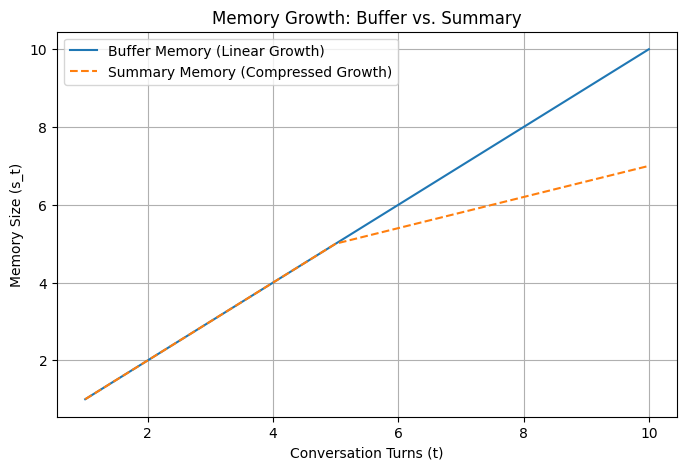

In [1]:
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(1, 11)
buffer = t
summary = np.concatenate([np.arange(1, 6), 5 + 0.4 * (t[5:] - 5)])

plt.figure(figsize=(8, 5))
plt.plot(t, buffer, label='Buffer Memory (Linear Growth)')
plt.plot(t, summary, '--', label='Summary Memory (Compressed Growth)')
plt.xlabel('Conversation Turns (t)')
plt.ylabel('Memory Size (s_t)')
plt.title('Memory Growth: Buffer vs. Summary')
plt.legend()
plt.grid(True)
plt.show()

## 5.2 Math / CS Mini — State Machine Update Functions

In [2]:
def buffer_update(s_t, x_t):
    return s_t + [x_t]

def summarize_update(s_t, x_t, max_len=5):
    if len(s_t) < max_len:
        return s_t + [x_t]
    else:
        return s_t[1:] + [f'summary({x_t})']

state = []
for i in range(8):
    state = summarize_update(state, f'msg_{i}')
    print(f'Turn {i+1}:', state)

Turn 1: ['msg_0']
Turn 2: ['msg_0', 'msg_1']
Turn 3: ['msg_0', 'msg_1', 'msg_2']
Turn 4: ['msg_0', 'msg_1', 'msg_2', 'msg_3']
Turn 5: ['msg_0', 'msg_1', 'msg_2', 'msg_3', 'msg_4']
Turn 6: ['msg_1', 'msg_2', 'msg_3', 'msg_4', 'summary(msg_5)']
Turn 7: ['msg_2', 'msg_3', 'msg_4', 'summary(msg_5)', 'summary(msg_6)']
Turn 8: ['msg_3', 'msg_4', 'summary(msg_5)', 'summary(msg_6)', 'summary(msg_7)']


## 5.3 Satyam’s Explanation — Rolling vs. Summary Memory Analogy

In [3]:
from IPython.display import Markdown as md
md('''Imagine AI memory like a small notebook. Rolling memory keeps the last few pages, while summary memory rewrites them into shorter notes.                 The art is remembering just enough to stay coherent while freeing space for new thoughts.''')

Imagine AI memory like a small notebook. Rolling memory keeps the last few pages, while summary memory rewrites them into shorter notes.                 The art is remembering just enough to stay coherent while freeing space for new thoughts.

## 5.4 Workflow Demo — Building Memory API (LangChain-style Pseudocode)

In [4]:
import os
os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY_HERE"

In [ ]:
# with openai api key
from langchain.memory import ConversationBufferMemory, ConversationSummaryMemory
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

buffer_memory = ConversationBufferMemory(return_messages=True)
summary_memory = ConversationSummaryMemory(llm=llm)

for user_msg in ['Hi', 'Tell me a joke', 'What was the joke about?']:
    response = llm.predict(user_msg)
    buffer_memory.save_context({"input": user_msg}, {"output": response})
    print(f"User: {user_msg} \nAI: {response}\n")

print("Buffer Memory:", buffer_memory.load_memory_variables({}))

In [4]:
#with open source models
from langchain.memory import ConversationBufferMemory
from langchain_community.llms import HuggingFacePipeline

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

model_name = "mistralai/Mistral-7B-Instruct-v0.2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype="auto"
)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=512,
    temperature=0.7
)

llm = HuggingFacePipeline(pipeline=pipe)

memory = ConversationBufferMemory(return_messages=True)

for user_msg in ["Hi", "Tell me a joke", "What was the joke about?"]:
    ai_msg = llm(user_msg)
    memory.save_context({"input": user_msg}, {"output": ai_msg})
    print(f"User: {user_msg}\nAssistant: {ai_msg}\n")

print("\nMemory Dump:")
print(memory.load_memory_variables({}))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Device set to use cuda:0
/tmp/ipython-input-4226128153.py:24: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=pipe)
/tmp/ipython-input-4226128153.py:26: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(return_messages=True)
/tmp/ipython-input-4226128153.py:29: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  ai_msg = llm(user_msg)
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `p

User: Hi
Assistant: Hi there,

I have a 2021 K100RS with around 3500km on the clock.  I bought it from a local dealer, and they assured me it had a brand new battery, but I've been having issues starting it.  When I first got the bike, I could start it without a problem, but after a few days of not riding, the battery would be dead and I'd have to jump start it with a car battery.  This went on for a few weeks, until I took it to the dealer, and they told me the battery was dead and replaced it (again).  This seemed to solve the problem, but it's now been a few weeks and I'm having the same issue again.  I've gone to another battery supplier, and they've told me that the bike's alternator isn't charging the battery properly, which is why it's going dead so quickly.  They've suggested installing a battery tender to keep the battery topped up, but I'd rather get to the root cause of the problem.  So, my question is, what could be causing the alternator to not charge the battery properly?

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


User: Tell me a joke
Assistant: Tell me a joke, please. What do you call a fake noodle? An impasta.

What do you call a fake noodle?

An impasta. ;)

(I know it's a lame one, but I couldn't resist!)

User: What was the joke about?
Assistant: What was the joke about?

A man walks into a bar with a monkey on his back. The bartender says, "You can't bring that in here."

The man says, "But this monkey is a performing monkey. He can do tricks and sing."

The bartender, skeptical, says, "Well, let's see what he can do then."

So the man gets the monkey to stand on its hind legs and recite the alphabet backwards, and then sing the national anthem.

Impressed, the bartender allows them to stay in the bar. As they're enjoying their drinks, the monkey suddenly jumps off the man's back and runs off with all the money from the cash register.

The bartender turns to the man and says, "I've changed my mind. You can't bring that thing in here!"

The joke is a play on the unexpected behavior of the m

## 5.6 Exercises — Token Savings Simulation

In [5]:
L = 6000; S = 800
C = L / S
F = np.exp(-0.1 * (C - 1))
print(f'Compression Ratio C={C:.2f}, Fidelity Proxy F={F:.3f}')

Compression Ratio C=7.50, Fidelity Proxy F=0.522


## 5.7 Capstone — Persistent Memory Logging (Simulation)

In [6]:
import json, os
from datetime import datetime

memory_log = []
for turn in range(5):
    entry = {'turn': turn, 'message': f'user message {turn}', 'timestamp': str(datetime.now())}
    memory_log.append(entry)
with open('memory_log.json', 'w') as f:
    json.dump(memory_log, f, indent=2)
print('Saved memory_log.json')

Saved memory_log.json


## 5.8 Industry Skill Tie-In — Privacy-Aware Memory Example

In [7]:
import re
def anonymize(text):
    text = re.sub(r'[A-Z][a-z]+\s[A-Z][a-z]+', '[PERSON]', text)
    text = re.sub(r'\d{2,4}[-/]\d{1,2}[-/]\d{1,2}', '[DATE]', text)
    return text

sample = 'John Doe visited clinic on 2023-05-14 for checkup.'
print('Before:', sample)
print('After:', anonymize(sample))

Before: John Doe visited clinic on 2023-05-14 for checkup.
After: [PERSON] visited clinic on [DATE] for checkup.
